In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Load datasets
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# Display basic information about the dataset
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


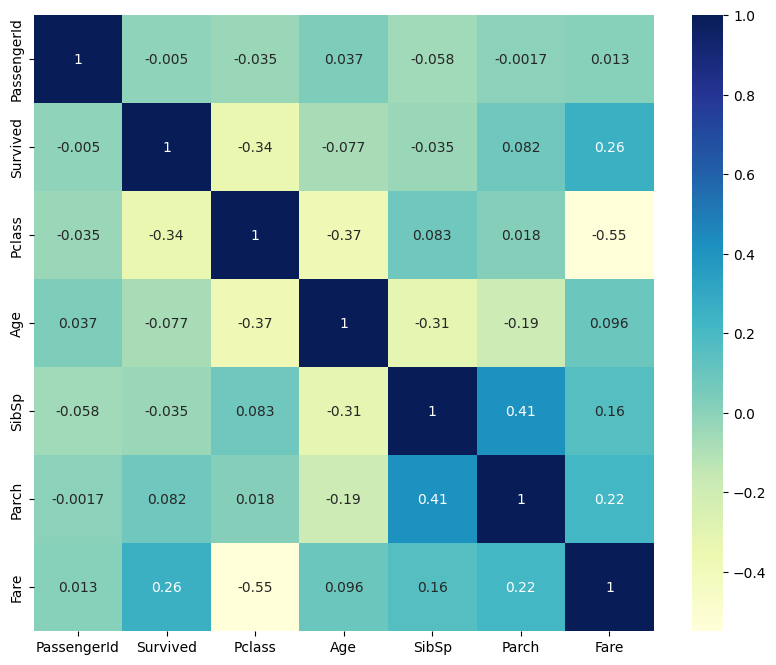

In [3]:
# Visualize correlations between numeric features
numeric_columns = train_data.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_columns.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [4]:
# Stratified shuffle split for maintaining distribution of target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices, test_indices in split.split(train_data, train_data[['Survived', 'Pclass', 'Sex']]):
    strat_train_set = train_data.loc[train_indices]
    strat_test_set = train_data.loc[test_indices]


In [5]:
# Impute missing 'Age' values
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X


In [6]:
# Encode categorical features
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        # Encode 'Embarked'
        embarked_matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        embarked_columns = ['Embarked_C', 'Embarked_S', 'Embarked_Q']
        for i in range(len(embarked_matrix.T)):
            X[embarked_columns[i]] = embarked_matrix.T[i]

        # Encode 'Sex'
        sex_matrix = encoder.fit_transform(X[['Sex']]).toarray()
        sex_columns = ['Female', 'Male']
        for i in range(len(sex_matrix.T)):
            X[sex_columns[i]] = sex_matrix.T[i]

        return X


In [10]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        # Encode 'Embarked'
        embarked_matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        embarked_columns = ['Embarked_C', 'Embarked_S', 'Embarked_Q']
        embarked_columns = embarked_columns[:embarked_matrix.shape[1]]  # Ensure matching number of columns
        for i in range(len(embarked_columns)):
            X[embarked_columns[i]] = embarked_matrix.T[i]

        # Encode 'Sex'
        sex_matrix = encoder.fit_transform(X[['Sex']]).toarray()
        sex_columns = ['Female', 'Male']
        sex_columns = sex_columns[:sex_matrix.shape[1]]  # Ensure matching number of columns
        for i in range(len(sex_columns)):
            X[sex_columns[i]] = sex_matrix.T[i]

        return X


In [11]:
# Define pipeline for preprocessing
pipeline = Pipeline([
    ("ageimputer", AgeImputer()),
    ("featureencoder", FeatureEncoder()),
    ("featuredropper", FeatureDropper())
])

# Apply preprocessing pipeline to training set
strat_train_set = pipeline.fit_transform(strat_train_set)

In [12]:
# Separate features and target variable
X_train = strat_train_set.drop(['Survived'], axis=1)
y_train = strat_train_set['Survived']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [13]:
# Define and tune Random Forest Classifier using GridSearchCV
param_grid = {
    "n_estimators": [10, 100, 200, 500],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 3, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

# Best estimator from GridSearchCV
final_classifier = grid_search.best_estimator_

In [14]:
# Apply preprocessing pipeline to test set
strat_test_set = pipeline.transform(strat_test_set)
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

# Scale test features
X_test_scaled = scaler.transform(X_test)

In [15]:
# Evaluate model on test set
test_accuracy = final_classifier.score(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.8268156424581006


In [16]:
# Apply preprocessing pipeline to entire training data for final model training
final_train_data = pipeline.fit_transform(train_data)
X_final_train = final_train_data.drop(['Survived'], axis=1)
y_final_train = final_train_data['Survived']
X_final_train_scaled = scaler.fit_transform(X_final_train)

In [17]:
# Train final production model
production_classifier = RandomForestClassifier()
grid_search = GridSearchCV(production_classifier, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_final_train_scaled, y_final_train)
production_classifier = grid_search.best_estimator_


In [20]:
# Preprocess test data for final predictions
final_test_data = pipeline.transform(test_data).ffill()
X_final_test_scaled = scaler.transform(final_test_data)

In [23]:
# Make predictions on the test set
final_predictions = production_classifier.predict(X_final_test_scaled)

# Display true labels vs predicted labels
print("Comparison of true labels vs predicted labels:")
print(pd.DataFrame({"True Labels": y_test, "Predicted Labels": final_classifier.predict(X_test_scaled)}).head(12))

Comparison of true labels vs predicted labels:
     True Labels  Predicted Labels
659            0                 0
119            0                 0
875            1                 1
67             0                 0
644            1                 1
257            1                 1
267            1                 0
69             0                 0
686            0                 0
850            0                 0
541            0                 0
851            0                 0
